# Proyecto 2
## Bioseñales y sistemas. 2024
### María J. Ostos, Cristian Florez, Juan A. Sañudo


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import scipy.signal as signal 
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import detrend
from scipy.signal import welch
from numpy.polynomial.polynomial import Polynomial
import os
from scipy import stats

1. De los artículos:

https://www.nature.com/articles/s41746-023-00966-w

https://www.nature.com/articles/s41598-020-59821-7

https://www.sciencedirect.com/science/article/pii/S2405844024032316

Para cada artículo hacer un diagrama de flujo de las metodologías usadas en los artículos (10%)

Explicar en sus palabras las metodologías desarrolladas (10%)

2. Descargar los datos ECGDataDenoised.zip de:
https://figshare.com/collections/ChapmanECG/4560497/1

De la base de datos extraer los registros que correspondan a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). Esta información está en el archivo Diagnostics.xlsx

In [3]:
fs=500

In [4]:
ruta_diagnostics="./otros/Diagnostics.xlsx"
df_diagnostics = pd.read_excel(ruta_diagnostics)

# Crear el nuevo dataframe filtrando por la columna 'Rhythm'
datos_diagnostics = df_diagnostics[(df_diagnostics['Rhythm'] == 'SB') | (df_diagnostics['Rhythm'] == 'AFIB')]

#Tamaño del nuevo dataframe
datos_diagnostics.shape


tiempo_diagnostics = np.arange(0, datos_diagnostics.shape[0]/fs,1/fs)

datos_diagnostics.head()


,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
5,MUSE_20180112_120347_79000,SB,NONE,46,FEMALE,57,57,70,404,393,38,24,9,225,260,427
6,MUSE_20180114_075026_69000,AFIB,TWC,80,FEMALE,98,86,74,360,459,69,83,17,215,252,395


In [5]:
datos_diagnostics.tail()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
9897,MUSE_20180114_134724_10000,SB,LVHV,56,FEMALE,56,56,88,444,428,49,62,9,219,263,441
9900,MUSE_20180113_122544_20000,SB,NONE,38,FEMALE,56,56,88,434,418,69,54,10,218,262,435
9902,MUSE_20180114_074720_85000,SB,NONE,55,FEMALE,57,57,94,414,402,-4,1,10,212,259,419
9903,MUSE_20180115_131524_93000,AFIB,RBBB TWC,70,MALE,93,82,130,386,479,61,194,15,225,290,418
9906,MUSE_20180116_133908_01000,SB,NONE,52,MALE,56,56,90,402,387,42,62,9,227,272,428


In [6]:
print(f'Tamaño del dataframe: {datos_diagnostics.shape} \nTamaño del vector tiempo: {tiempo_diagnostics.shape[0]}')

Tamaño del dataframe: (5669, 16) 
Tamaño del vector tiempo: 5669


De estos registros los análisis para el presente proyecto deben hacerse en la derivación II

In [7]:
ruta_II="./otros/MUSE_20180113_171327_27000.csv"
df_II = pd.read_csv(ruta_II,delimiter=',',names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

datos_II = df_II["II"]

tiempo_II = np.arange(0, datos_II.shape[0]/fs,1/fs)

datos_II.head()

0    381.94
1    381.92
2    380.63
3    376.53
4    368.14
Name: II, dtype: float64

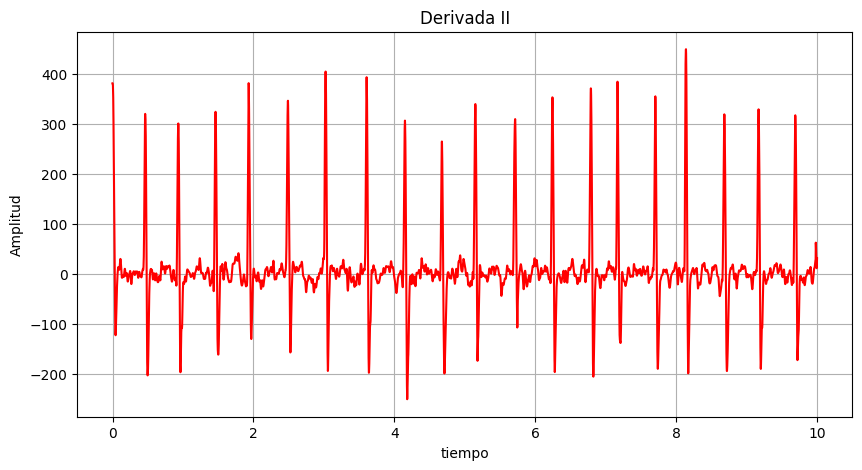

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(tiempo_II,datos_II, color='r', linestyle='-')
plt.title('Derivada II')
plt.xlabel('tiempo')
plt.ylabel('Amplitud')
# plt.legend()
plt.grid()
plt.show()


3. Programar las fórmulas 1 al 4 que se encuentran en el artículo (15%). Consultar que significado y utilidad del biespectro (Realice la gráfica) (5%)
https://arxiv.org/pdf/1809.08451

## Significado de las funciones:
- ### Deviation:  
la desviación media cuadrática (ECM) es una métrica que ayuda a medir la diferencia de los datos originales con los datos a los que se les aplico detrend
- ### Compress:
La función comprime la señal a realizar la normalización de la señal entre 0 y 1
- ### Bispectrum:
Es una herramienta matemática utilizada en el análisis de señales que proporciona información sobre las relaciones de fase y amplitud entre tres componentes de frecuencia diferentes en una señal
- ### Bicoherence:
Es una medida normalizada del biespectro, que indica la coherencia de las interacciones de tercer orden. Valores cercanos a 1 indican una fuerte interacción no lineal.

In [9]:
def Grafica(tiempo,data,datos_process,nombre="Procesado"):
    
    # Crear una figura con dos subplots en una fila
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 4))
    # Graficar en el primer subplot
    ax1.plot(tiempo,data, color="k")
    ax1.set_title('Original')
    ax1.grid(True)
    # Graficar en el segundo subplot
    ax2.plot(tiempo,datos_process, color="r", linestyle='-')
    ax2.set_title(nombre)
    ax2.grid(True)
    plt.show()

In [10]:
#Ecuación 1
def detrend_n_deviation(data,tiempo):
    datos_detrend=signal.detrend(data)
    datos_deviation=np.mean((data-datos_detrend)**2)
    return datos_detrend, datos_deviation

In [11]:
# Ecuación 2
def compress(signal):
    xmin, xmax = np.min(signal), np.max(signal)
    if xmin == xmax:
        return signal  # Evitar dividir por cero si no hay rango
    compressed_signal = (signal - xmin) / (xmax - xmin)
    return np.array(compressed_signal)

In [12]:
#Ecuaciones 3 y 4
def bispectrum_bicoherence(signal, fs, segment):
    # Dividir la señal en segmentos de longitud nfft
    segmentos = [signal[i:i + segment] for i in range(0, len(signal) - segment + 1, segment)]
    segmentos = np.array(segmentos)
    num_segmentos = segmentos.shape[0]

    # Aplicar la Transformada de Fourier a cada segmento
    fft_segmentos = np.fft.fft(segmentos, n=segment, axis=1)[:, :segment // 2]

    # Inicializar matrices para el bispectro y la bicoherencia
    bispectro = np.zeros((segment // 2, segment // 2), dtype=complex)
    acumulado = np.zeros((segment // 2, segment // 2), dtype=complex)

    # Calcular el bispectro y el valor acumulado para la bicoherencia
    for k in range(num_segmentos):
        S = fft_segmentos[k, :]
        for f1 in range(segment // 2):
            for f2 in range(f1, segment // 2 - f1):
                f3 = f1 + f2
                if f3 < segment // 2:  # Evitar exceder los límites del espectro
                    producto = S[f1] * S[f2] * np.conj(S[f3])
                    bispectro[f1, f2] += producto
                    acumulado[f1, f2] += np.abs(producto)

    # Normalizar el bispectro para obtener la bicoherencia
    bicoherencia = np.abs(bispectro) / acumulado

    # Aplicar simetría a la matriz de bicoherencia
    return bispectro, bicoherencia


def aplicar_simetria(matriz):
    matriz_simetrica = np.zeros_like(matriz)
    for f1 in range(matriz.shape[0]):
        for f2 in range(f1, matriz.shape[1] - f1):
            matriz_simetrica[f1, f2] = matriz[f1, f2]
    return matriz_simetrica


4. Para cada señal extraer la frecuencia que contiene la máxima potencia y Gráfiquela (15%)

In [13]:
# Función para calcular la frecuencia de máxima potencia
def max_power_frequency(signal, fs):
    # Calcular la transformada de Fourier del señal
    fft_vals = np.fft.fft(signal)
    # Mantener solo la mitad de los valores (espectro positivo)
    fft_magnitude = np.abs(fft_vals[:len(fft_vals)//2])
    # Calcular las frecuencias correspondientes
    frequencies = np.fft.fftfreq(len(signal), d=1/fs)[:len(fft_vals)//2]
    # Calcular la potencia en el dominio de la frecuencia
    power_spectrum = fft_magnitude**2
    # Encontrar el índice de la frecuencia con máxima potencia
    max_power_idx = np.argmax(power_spectrum)
    # Obtener la frecuencia de máxima potencia y el valor de la potencia máxima
    max_frequency = round(frequencies[max_power_idx], 5)
    max_power_value = power_spectrum[max_power_idx]
    # Graficar la magnitud de la transformada de Fourier y marcar la frecuencia de máxima potencia
    plt.figure()
    plt.plot(frequencies, fft_magnitude)
    plt.axvline(x=max_frequency, color='k', linestyle='--', label=f'Máxima Frecuencia: {max_frequency} Hz')
    plt.legend()
    
    return max_frequency, max_power_value

5. Para cada señal sumar el número de frecuencias que son significativas para bicoherencia (cuales tienen un valor superior a ![image](https://github.com/user-attachments/assets/636a4170-c3f7-4789-9100-f2a0ce0033c3) ) (20%)

In [14]:
# Función para sumar las frecuencias significativas en bicoherencia
def significant_frequencies_bicoherence(bicoherence, N):
    threshold = np.sqrt(9.2 / (2 * N))
    significant_frequencies = np.sum(bicoherence > threshold)
    return significant_frequencies


6. Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 al 5 y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP) y suma de frecuencias significativas en bicoherencia (sFSB):

| Registro | Estado | fMP | sFSB  |
| --- | --- | --- | --- |
| --- | --- | --- | --- |
| --- | --- | --- | --- |


In [15]:
def signal_process(datos,tiempo,fs):
    print("Aplicando detrend")
    data_detrended=detrend_n_deviation(datos,tiempo)
    print(f'La desviación es {data_detrended[1]}')
    Grafica(tiempo,datos,data_detrended[0],nombre="Detrended")

    print("Aplicando compress")
    data_compressed=compress(data_detrended[0])
    Grafica(tiempo,data_detrended[0],data_compressed,"Compressed")
    
    print("Aplicando biespectro y bicoherencia")
    bisp_Bic=bispectrum_bicoherence(data_compressed,fs,1000)
    # Grafica(datos[:len(bisp_Bic[0])],data_compressed[:len(bisp_Bic[0])],bisp_Bic[0],"bispectrum and bicoherence")
    Grafica(tiempo[:len(bisp_Bic[0])],data_compressed[:len(bisp_Bic[0])],bisp_Bic[0],"bispectrum")
    # Calcular el bispectro
    bisp_Bic = bispectrum_bicoherence(datos_II, fs, 1000)
    bisp_Bic= aplicar_simetria(bisp_Bic[1])
    # Graficar el bicoherence
    plt.figure(figsize=(8, 5))
    plt.imshow(np.abs(bisp_Bic), extent=(0, 20, 0, 10), aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Magnitud de bicoherencia')
    plt.xlabel('Frecuencia f1 (Hz)')
    plt.ylabel('Frecuencia f2 (Hz)')
    plt.title('Bicoherencia Simétrica')
    plt.show()
    
    print("calculando la máxima potencia")
    max_p=max_power_frequency(datos,fs)
    print(f'La máxima potencia es {[max_p]}')
    # plt.figure(figsize=(10, 5))
    # # plt.semilogy(max_p[1], max_p[2], label='Densidad Espectral de Potencia')
    # plt.axvline(max_p[0], color='r', linestyle='--', label=f'Máxima Frecuencia: {max_p[0]:.2f} Hz')
    
    # plt.plot(max_p[1], max_p[2])
    # plt.xlim([0,20])

    
    plt.title('Densidad Espectral de Potencia')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Densidad Espectral [V^2/Hz]')
    plt.legend()
    plt.grid()
    plt.show()

    print("calculando Frecuencias significativas")
    sig_f=significant_frequencies_bicoherence(bisp_Bic[1],len(bisp_Bic[1]))
    print(f'Frecuencias significativas para bicoherencia: {sig_f} Hz \n')
    
    return data_detrended, data_compressed, bisp_Bic, max_p, sig_f
    
    

### Aplicar procesado a señal de derivada II

Aplicando detrend
La desviación es 74.91493430408316


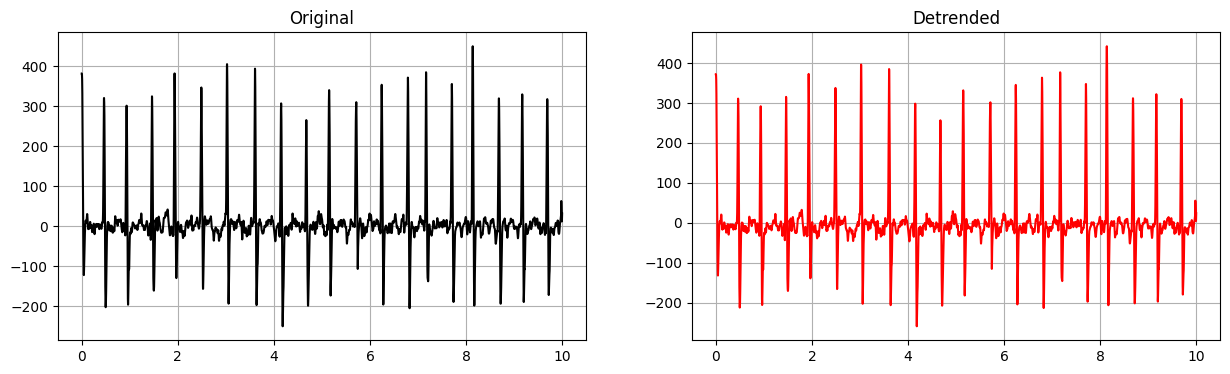

Aplicando compress


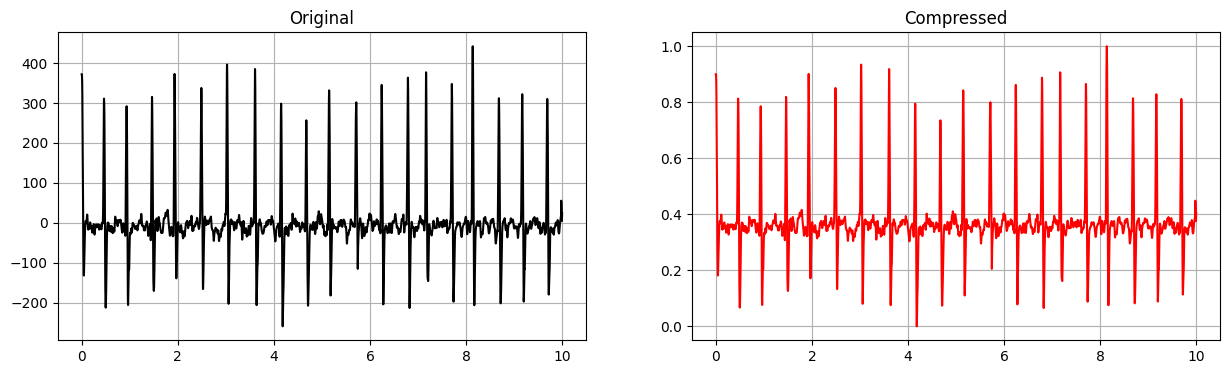

Aplicando biespectro y bicoherencia


C:\Users\crist\AppData\Local\Temp\ipykernel_13012\3190863204.py:27: RuntimeWarning: invalid value encountered in divide
  bicoherencia = np.abs(bispectro) / acumulado
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


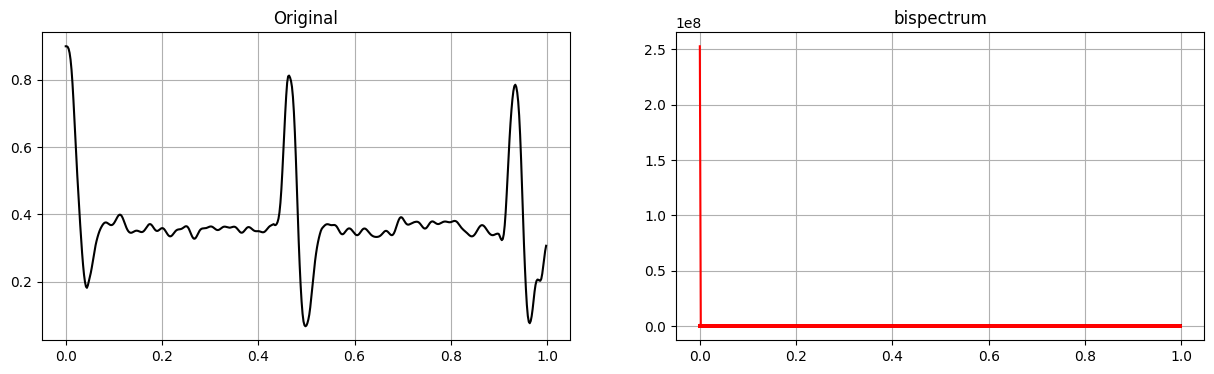

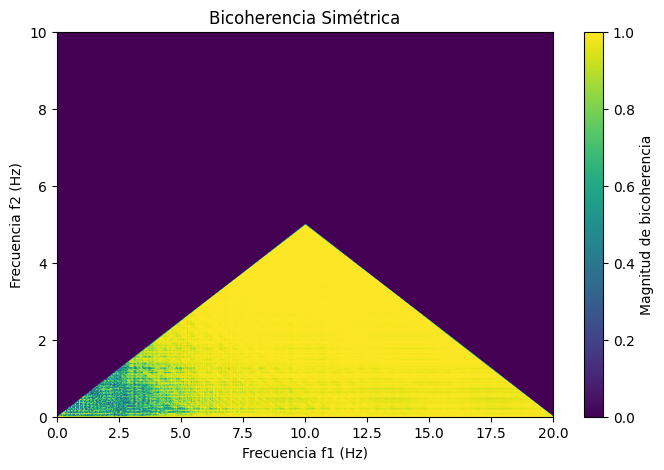

calculando la máxima potencia
La máxima potencia es [(np.float64(9.0), np.float64(4817064847.794896))]


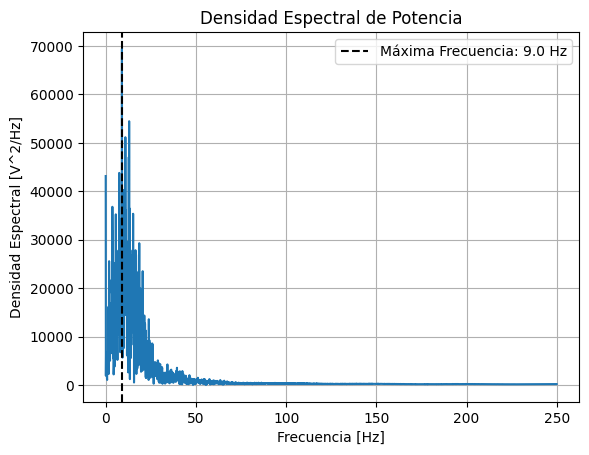

calculando Frecuencias significativas
Frecuencias significativas para bicoherencia: 497 Hz 



((array([372.18342396, 372.16387432, 370.87432468, ...,   6.22988158,
          13.62133194,  23.9587823 ]),
  np.float64(74.91493430408316)),
 array([0.90017325, 0.90014539, 0.89830748, ..., 0.37860504, 0.38913956,
        0.40387282]),
 array([[1.        +0.j, 1.        +0.j, 1.        +0.j, ...,
         1.        +0.j, 1.        +0.j, 1.        +0.j],
        [0.        +0.j, 0.53588561+0.j, 0.63066724+0.j, ...,
         0.99457344+0.j, 0.99498203+0.j, 0.        +0.j],
        [0.        +0.j, 0.        +0.j, 0.70472052+0.j, ...,
         0.99548428+0.j, 0.        +0.j, 0.        +0.j],
        ...,
        [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
         0.        +0.j, 0.        +0.j, 0.        +0.j],
        [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
         0.        +0.j, 0.        +0.j, 0.        +0.j],
        [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
         0.        +0.j, 0.        +0.j, 0.        +0.j]]),
 (np.float64(9.0), np.float

In [16]:
signal_process(datos_II,tiempo_II,fs)

7. Para las señales de análisis del punto 2 aplicar las rutinas del punto 3 al 5 y hacer un informe que permita evidenciar las diferencias entre las señales SB y AFIB utilizando las herramientas de estadística descriptiva (5%)

Procesando el archivo MUSE_20180113_171327_27000.csv

Aplicando detrend
La desviación es 74.91493430408316


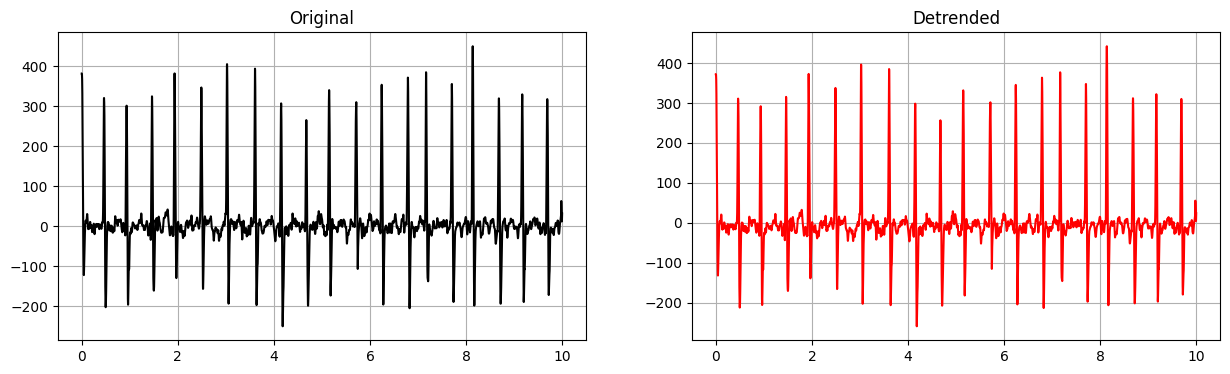

Aplicando compress


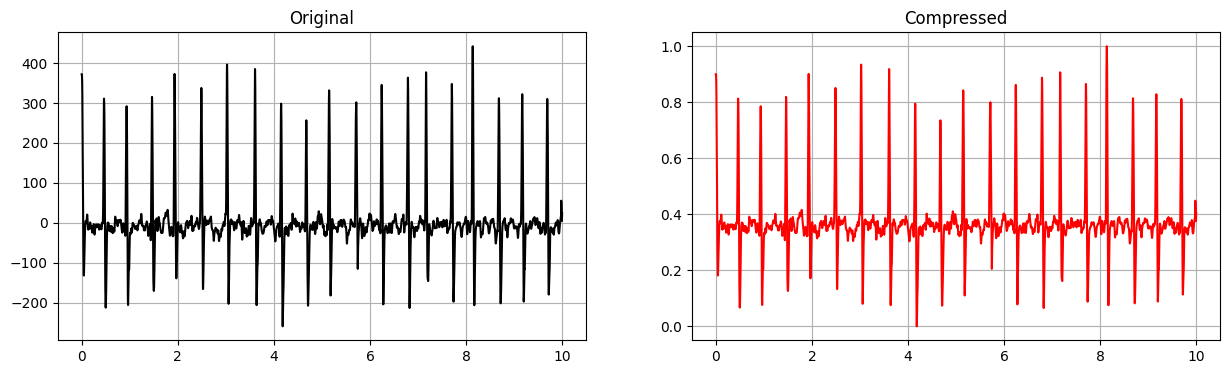

Aplicando biespectro y bicoherencia


C:\Users\crist\AppData\Local\Temp\ipykernel_13012\3190863204.py:27: RuntimeWarning: invalid value encountered in divide
  bicoherencia = np.abs(bispectro) / acumulado
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


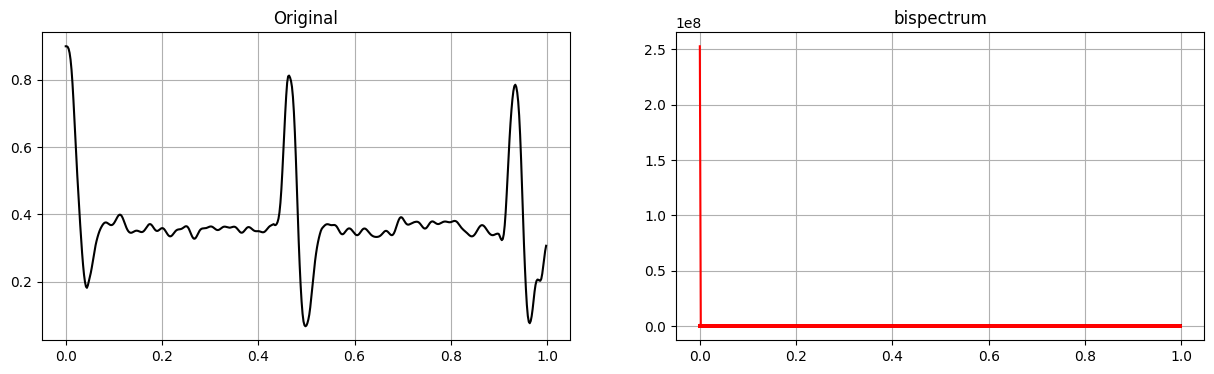

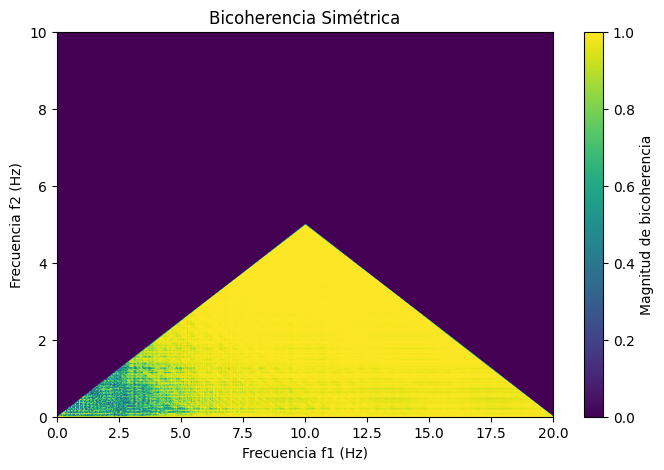

calculando la máxima potencia
La máxima potencia es [(np.float64(9.0), np.float64(4817064847.794896))]


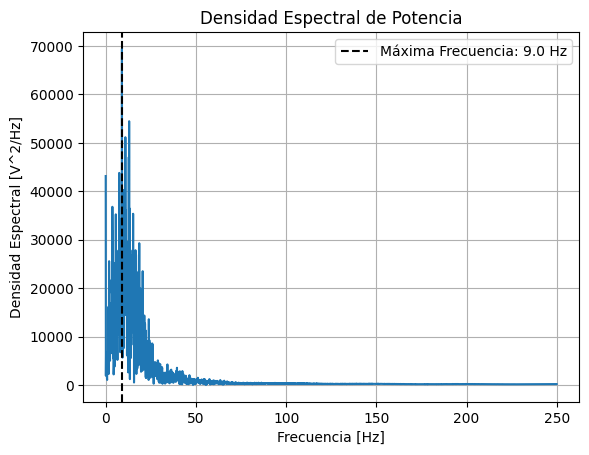

calculando Frecuencias significativas
Frecuencias significativas para bicoherencia: 497 Hz 

Procesando el archivo MUSE_20180111_155154_74000.csv

Aplicando detrend
La desviación es 491.10102107958755


C:\Users\crist\AppData\Local\Temp\ipykernel_13012\2902501765.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados = pd.concat([df_resultados,


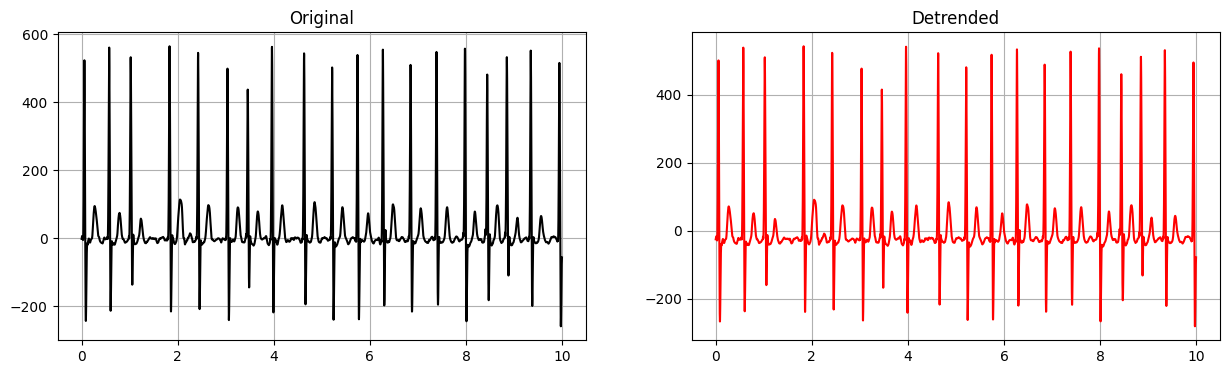

Aplicando compress


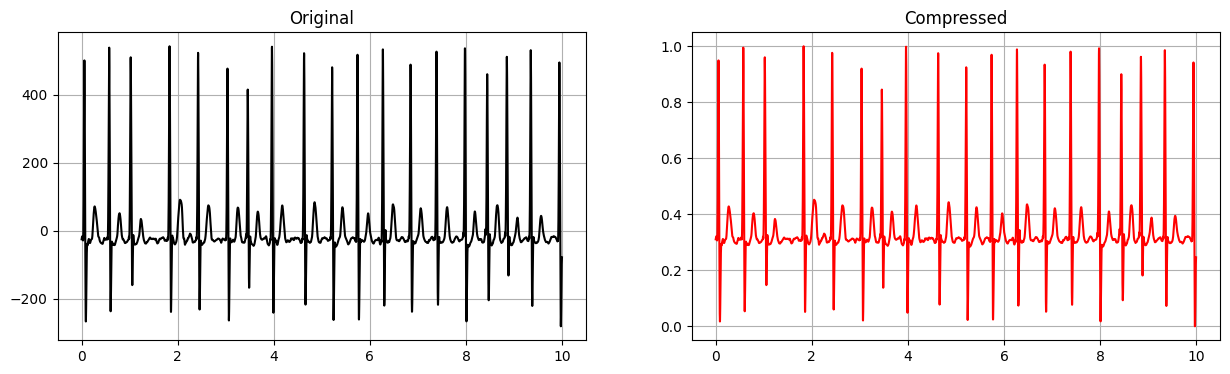

Aplicando biespectro y bicoherencia


C:\Users\crist\AppData\Local\Temp\ipykernel_13012\3190863204.py:27: RuntimeWarning: invalid value encountered in divide
  bicoherencia = np.abs(bispectro) / acumulado
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


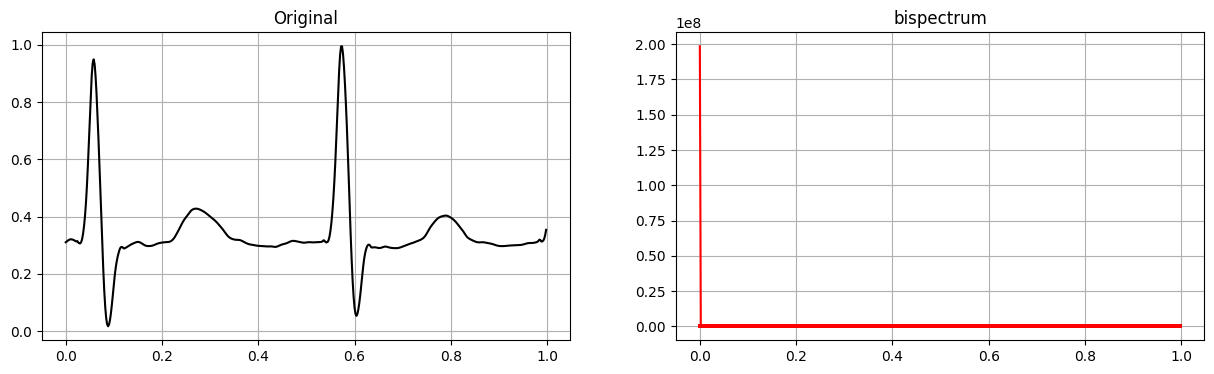

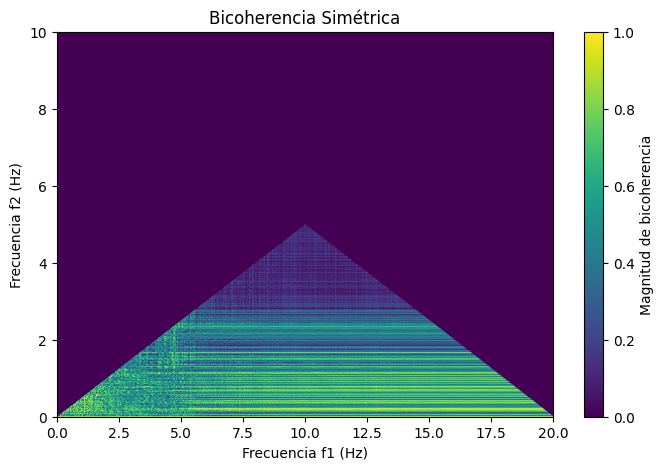

calculando la máxima potencia
La máxima potencia es [(np.float64(0.0), np.float64(12271579087.913946))]


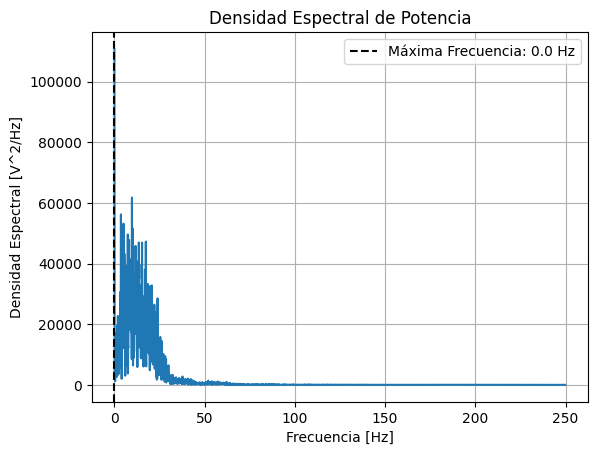

calculando Frecuencias significativas
Frecuencias significativas para bicoherencia: 493 Hz 

Procesando el archivo MUSE_20180114_074720_85000.csv

Aplicando detrend
La desviación es 35.81014976026927


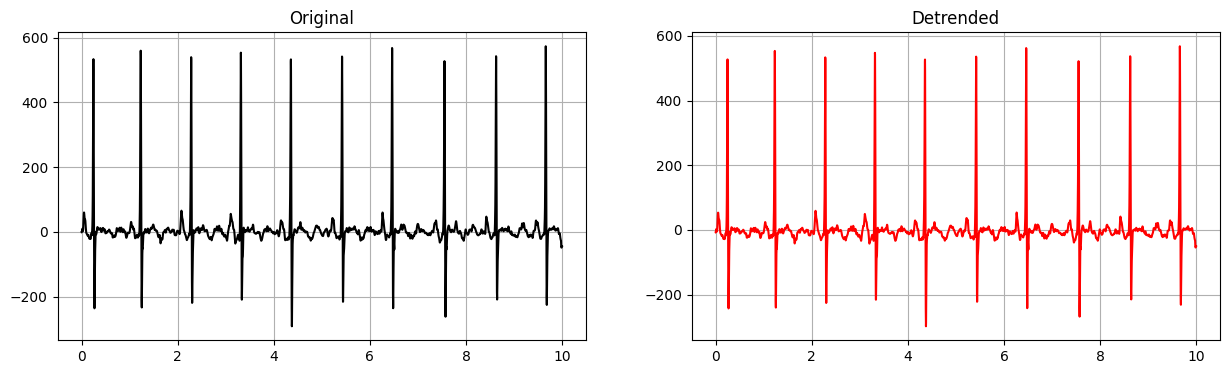

Aplicando compress


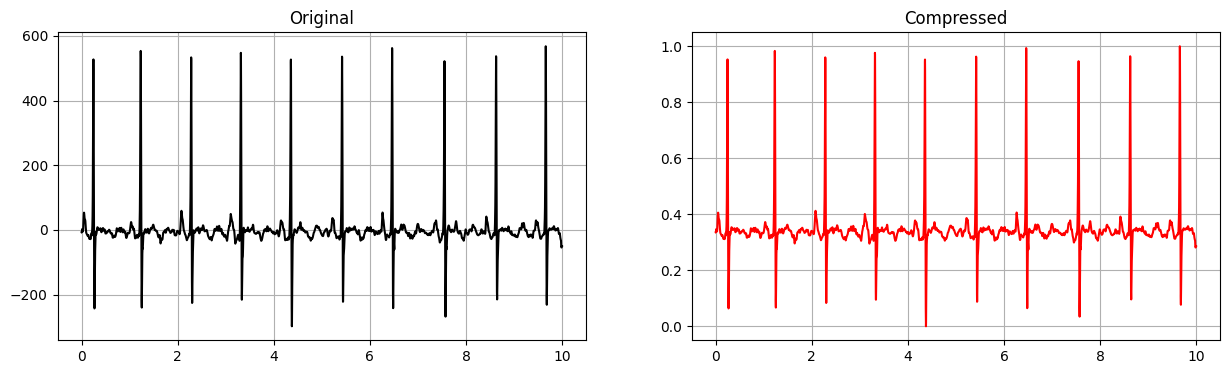

Aplicando biespectro y bicoherencia


C:\Users\crist\AppData\Local\Temp\ipykernel_13012\3190863204.py:27: RuntimeWarning: invalid value encountered in divide
  bicoherencia = np.abs(bispectro) / acumulado
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


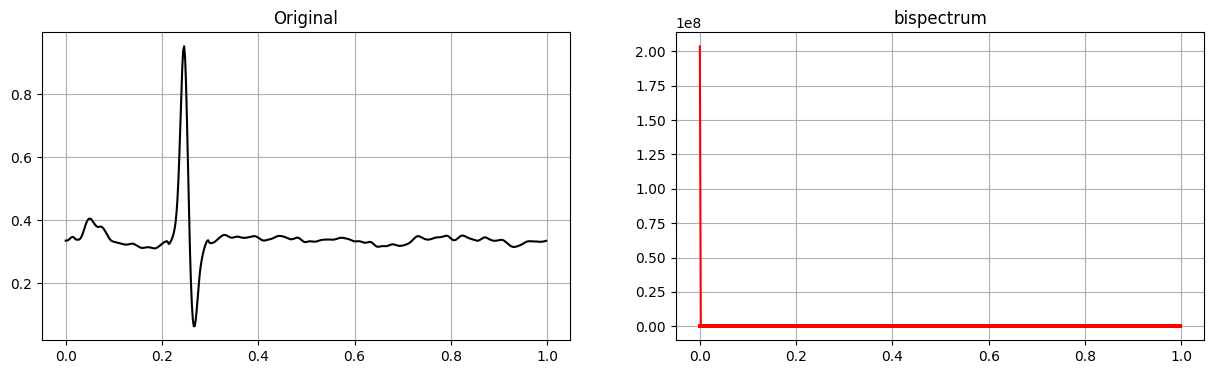

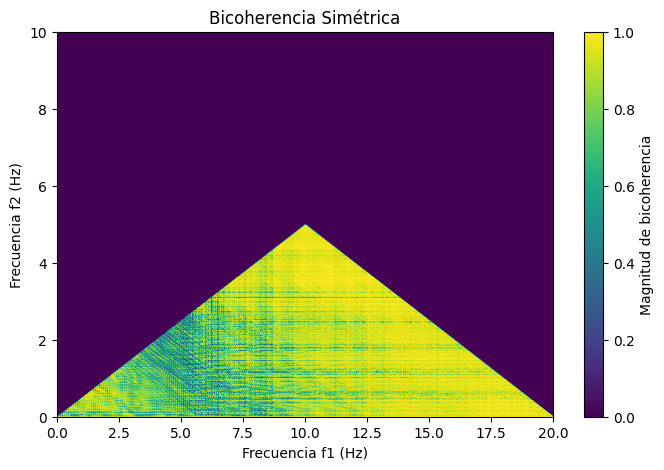

calculando la máxima potencia
La máxima potencia es [(np.float64(15.3), np.float64(1374272242.812524))]


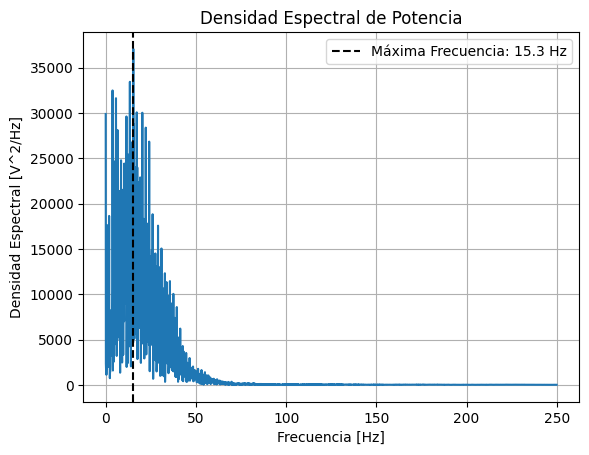

calculando Frecuencias significativas
Frecuencias significativas para bicoherencia: 493 Hz 

Procesando el archivo MUSE_20180114_134724_10000.csv

Aplicando detrend
La desviación es 3473.5285599067315


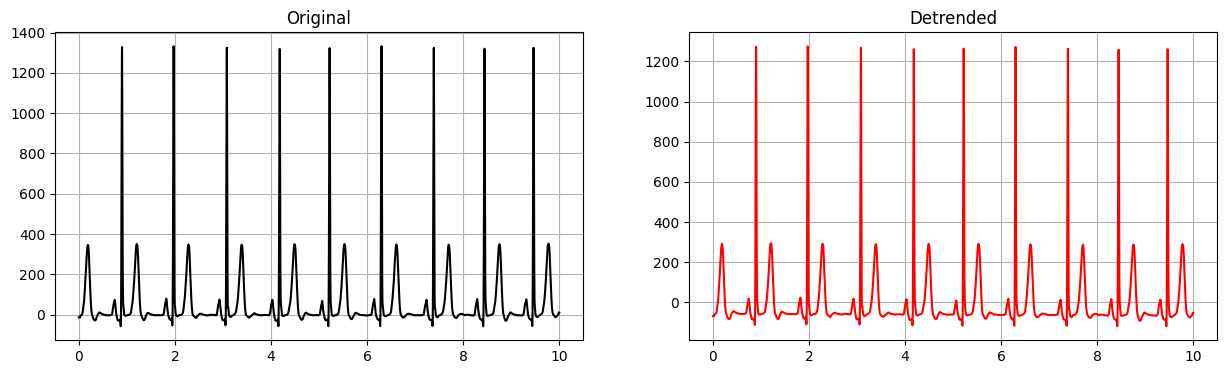

Aplicando compress


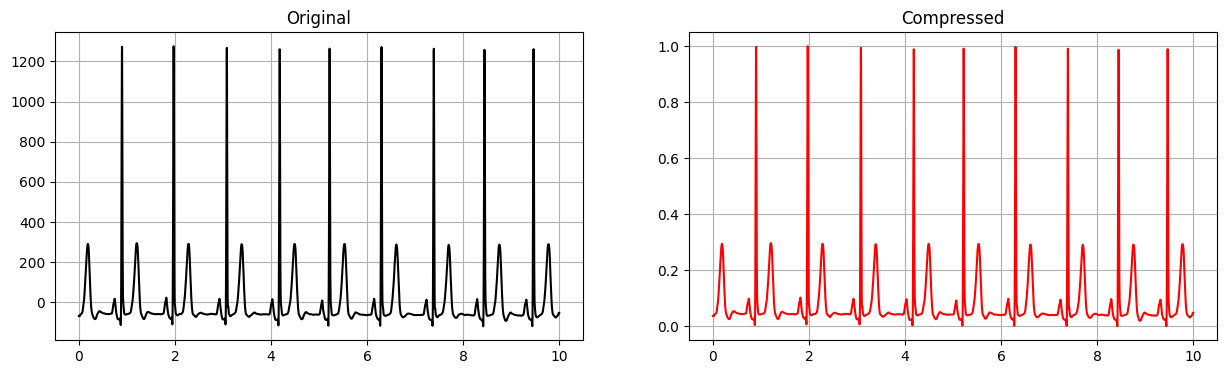

Aplicando biespectro y bicoherencia


C:\Users\crist\AppData\Local\Temp\ipykernel_13012\3190863204.py:27: RuntimeWarning: invalid value encountered in divide
  bicoherencia = np.abs(bispectro) / acumulado
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


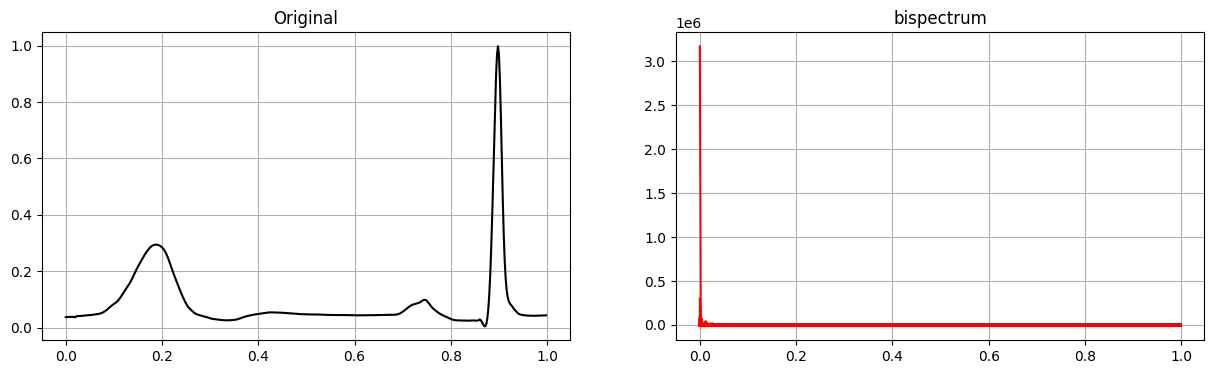

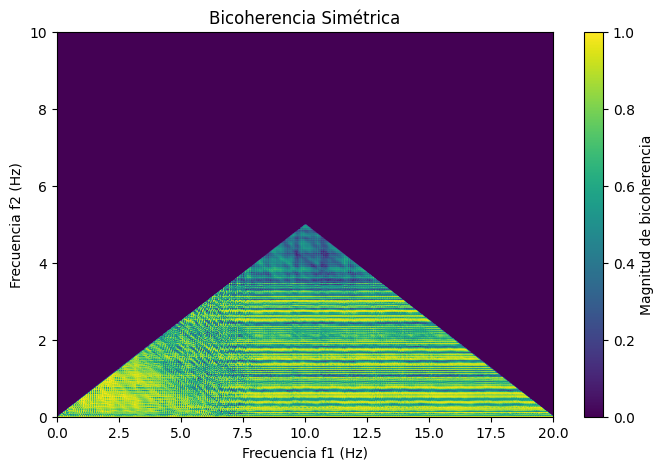

calculando la máxima potencia
La máxima potencia es [(np.float64(0.0), np.float64(86697820010.03464))]


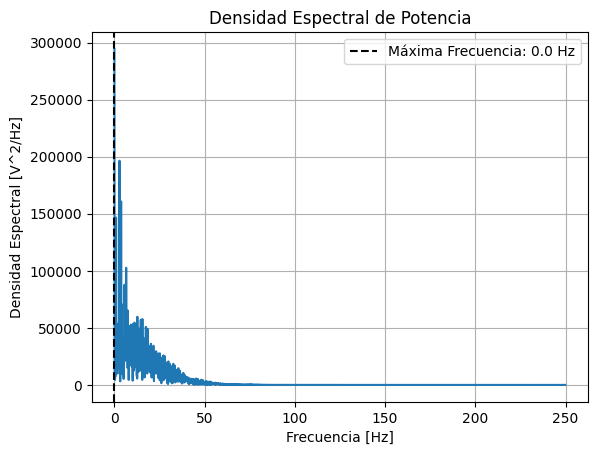

calculando Frecuencias significativas
Frecuencias significativas para bicoherencia: 493 Hz 



In [17]:
# Ruta a la carpeta donde se encuentran los archivos
ruta_carpeta = "./otros/"

# Nombre del archivo de Excel
nombre_excel = "Diagnostics.xlsx"

# Nombres de los archivos CSV a procesar (ajusta según tus necesidades)
# archivos_csv = ["MUSE_20180113_171327_27000.csv", "MUSE_20180114_075026_69000.csv", "MUSE_20180112_073319_29000.csv", "MUSE_20180112_120347_79000.csv"]
# archivos_csv = ["MUSE_20180113_171327_27000.csv", "MUSE_20180113_122544_20000.csv", "MUSE_20180114_074720_85000.csv", "MUSE_20180114_134724_10000.csv"]
archivos_csv = ["MUSE_20180113_171327_27000.csv", "MUSE_20180111_155154_74000.csv", "MUSE_20180114_074720_85000.csv", "MUSE_20180114_134724_10000.csv"]

# Leer el archivo de Excel
df_excel = pd.read_excel(os.path.join(ruta_carpeta, nombre_excel))

# Crear un DataFrame vacío para almacenar los resultados
df_resultados = pd.DataFrame(columns=["Registro", "Estado", "fMP", "sFSB"])

for archivo in archivos_csv:
    # Leer el archivo CSV
    # df_csv = pd.read_csv(os.path.join(ruta_carpeta, archivo))
    df_csv = pd.read_csv(os.path.join(ruta_carpeta, archivo), delimiter=',',names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    datos_II = df_csv["II"]
    
    tiempo = np.arange(0, datos_II.shape[0]/fs,1/fs)
    
    # Obtener el nombre del sujeto (sin extensión .csv)
    nombre_sujeto = archivo[:-4]

    # Encontrar la fila correspondiente en el DataFrame de Excel
    fila_excel = df_excel[df_excel['FileName'] == nombre_sujeto]  # Ajusta 'Nombre_Sujeto' al nombre de la columna en tu Excel

    # Verificar si se encontró la fila
    if not fila_excel.empty:
        print(f'Procesando el archivo {archivo}\n')
        # Obtener el estado del sujeto
        estado = fila_excel['Rhythm'].values[0]

        resultados_proceso=signal_process(datos_II,tiempo,fs)
        
        # Calcular bispectrum y bicoherence (ajusta los parámetros según tus necesidades)
        # bispectrum, bicoherence = bispectrum_bicoherence(df_csv['Columna_de_datos'].values, N=1024)
        

        # F_max=resultados_proceso[4]
        F_max=resultados_proceso[3][0]
        F_sig=resultados_proceso[4]
        
        df_resultados = pd.concat([df_resultados,
                           pd.DataFrame({'Registro': nombre_sujeto,
                                         'Estado': estado,
                                         'fMP': F_max,
                                         'sFSB': F_sig},
                                        index=[0])
                           ],
                          ignore_index=True)
    else:
        print(f"No se encontró el sujeto {nombre_sujeto} en el archivo de Excel.")

# Guardar los resultados en un nuevo archivo CSV
# df_resultados.to_csv("resultados.csv", index=False)

In [18]:
df_resultados

,Registro,Estado,fMP,sFSB
0,MUSE_20180113_171327_27000,AFIB,9.0,497
1,MUSE_20180111_155154_74000,AFIB,0.0,493
2,MUSE_20180114_074720_85000,SB,15.3,493
3,MUSE_20180114_134724_10000,SB,0.0,493


8. Indicar si hay o no diferencias estadísticas entre las características espectrales del punto 4 y 5 para las dos poblaciones de estudio (5%)


Prueba de Normalidad

Hipótesis nula (Ho): Los datos recolectados del ECG no distribuyen normal
 
Hipotesis alternativa (H1): Los datos distribuyen de manera normal

In [19]:
#Prueba de Normalidad
alpha=0.05 #Valor de significancia de 5%
cols=df_resultados.columns[2:]
for i in cols: 
    [statistic,pvalue]=stats.normaltest(df_resultados[i])
    if pvalue > alpha:
        print(f'la columna {i} distribuye normal')
    else:
        print(f'la columna {i} no distribuye normal')

la columna fMP no distribuye normal
la columna sFSB no distribuye normal


C:\Users\crist\AppData\Local\Temp\ipykernel_13012\4270902246.py:5: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  [statistic,pvalue]=stats.normaltest(df_resultados[i])


Prueba Homocedasticidad  
Hipótesis nula (Ho): Los varianza de los datos recolectados del ECG no son significativamente diferentes 

Hipotesis alternativa (H1): La varianza de los datos son significativamente diferentes

In [20]:
#Prueba Homocedasticidad  
# [statistic,pvalue]=stats.levene(ciclos[2],ciclos[3],ciclos[13],ciclos[14])
[statistic,pvalue]=stats.levene(df_resultados["fMP"],df_resultados["sFSB"])
print(f'Valor p: {pvalue} \n')
if pvalue > alpha:
    print('Cumple supuesto de homocedasticidad') #Varianzas no son significativamente diferentes
else:
    print('No cumple supuesto de homocedasticidad')

Valor p: 0.0346316797545032 

No cumple supuesto de homocedasticidad


Prueba Mann-Whitney

Hipótesis nula (Ho): No hay diferencia entre la frecuencia significativa en bicoherencia entre pacientes con bradicardia sinusal (SB) y fibrilación auricular (AFIB) 
Hipotesis alternativa (H1): Si hay diferencia de la frecuencia significativa en bicoherencia entre pacientes con bradicardia sinusal (SB) y fibrilación auricular (AFIB)

In [21]:
#Prueba Mann-Whitney
df_resultados["sFSB"]= pd.to_numeric(df_resultados["sFSB"], errors='coerce')
grupo1 = df_resultados["fMP"]
grupo2 = df_resultados["sFSB"]
[statistic,pvalue]=stats.mannwhitneyu(grupo1,grupo2)
if pvalue < alpha:
    print('Existe diferencia significativa entre fMP y sFSB ')
else:
    print('No existe diferencia significativa entre fMP y sFSB') 
print(f'Valor p: {pvalue} \n')



Existe diferencia significativa entre fMP y sFSB 
Valor p: 0.025580146726954023 



Cómo los datos no distribuyen de manera normal ni cumplen con el supuesto de homocedasticidad, se aplica la prueba Mann-WHitney, obteniendo cómo resultado que se rechaza la hipótesis nula de que no hay diferencias entre las dos poblaciones de estudio, esto significa que hay diferencia entre las medidas de bicoherencia entre los pacientes con bradicardia sinusal y fibrilación auricular, debido a que estas dos enfermedades generan potencia en otras y más frecuencias diferentes a las que normalmente el corazón funciona (1-2Hz), es decir tienen una potencia que sobre pasa el 80% en otras frecuencias, permitiendo concluir que estas dos arritmias presenta un aumento en la potencia del ECG en frecuencias determinadas que pueden ser servir como diagnóstico para detectar estás arritmias a tiempo. En pocas palabras estás dos arritmias tienen diferencias importantes en la interacción de frecuencias en las señales cardíacas